# Chapter 15 - Mark and Recapture

- Sample some things from a population, mark them, and then take another sample to see how many of those are ones that we previously captured.
- Originally used in ecology, but have applications in lots of other fields
- Also we'll use a distribution with three paramters

## The Grizzly Bear Problem

- Researchers deployed "traps" to capture the hair of grizzly bears
- First session: identified 23 different bears
- Second session: 19 different bears, of which 4 had previously been captured

To estimate the population, let's start with the assumption that each bear has roughly the same probability of being captured.

To start, let's assume that the actual population is 100.

After the first session, 23 of the 100 bears have been identified. During the second session, if we choose 19 bears at random, what is the probability that 4 of them were previously defined?

Define:
- $N$, the actual population: 100
- $K$, the number of bears identified in the first session: 23
- $n$, the number of bears identified in the second session: 19
- $k$, the number of bears in the second session that were previously identified: 4

For given values of $N$, $K$, and $n$, the probability of finding $k$ previously-identified bears if given by the hypergeometric distribution:

$$
\frac{\binom{K}{k} \binom{N-K}{n-k}}{\binom{N}{n}}
$$

`scipy.stats` contains the `hypergeom` to compute this:

<AxesSubplot:>

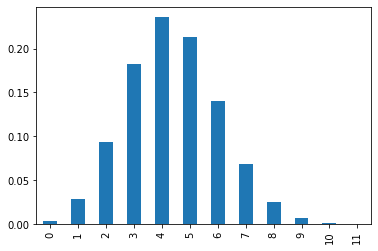

In [1]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import hypergeom

N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)
pmf = Pmf(ps, ks)
pmf.plot(kind="bar")

## The Update

Let's say that an expert estimates that the true population is between 50 and 500, and is equally likely to be any value in that range.

In [2]:
from utils import make_uniform

qs = np.arange(50, 501)
prior_N = make_uniform(qs)
prior_N.shape

(451,)

<AxesSubplot:>

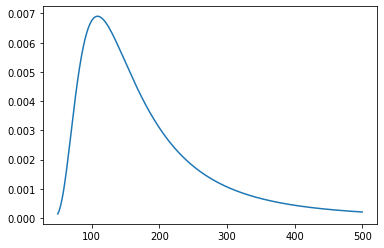

In [3]:
# to compute the likelihood:
Ns = prior_N.qs
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

posterior_N = prior_N * likelihood
posterior_N.normalize()
posterior_N.plot()

In [4]:
posterior_N.max_prob()

109

In [5]:
posterior_N.mean()

173.79880627085637

In [6]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

This solution is pretty simple, but it turns out that we can do better if we model the unknown probability of observing a bear explicitly.

## Two-Parameter Model
Let's try a model with two parameters:
- $N$, the population
- $p$, the probability of observing a bear

We'll assume that $p$ is the same for both rounds, which seems reasonable since the traps were in the same location, &c.

We'll also assume that the $p$s are independent (that is, the probability of a bear being seen in round 2 is the same regardless of whether it was seen in round 1. A little suspect, but we'll go with it.

In [7]:
# k10 - number of bears observed in round 1 but not round 2
# k01 - number observed in the second round but not the first
# k11 - number observed in both

k10 = 23 - 4
k01 = 19 - 4
k11 = 4

# If we knew the actual values of N and p. Then we could calculate the likelihood:
N = 100
observed = k01 + k10 + k11
k00 = N - observed
k00

62

In [8]:
# store the results in a list representing the number of bears in each category
x = [k00, k01, k10,  k11]
x

[62, 15, 19, 4]

In [9]:
# now let's pretend that we know the p = 0.2, and calculate the probability of a bear being in each category:
p = 0.2
q = 1 - p
y = [q*q, p*q, q*p, p*p] # probabilities of being in each category
y

[0.6400000000000001,
 0.16000000000000003,
 0.16000000000000003,
 0.04000000000000001]

Now, the probability of the data is given by the multinomial distribution:

$$
\frac{N!}{\Pi x_i!} \Pi y_i^{x_i}
$$

In [10]:
from scipy.stats import multinomial

likelihood = multinomial.pmf(x, N, y)
likelihood

0.0016664011988507257

of course, we don't know N or p, so we'll choose prior distributions for N and p and go from there

## The Prior

We'll use `prior_N` again from before, and a uniform prior for $p$

In [11]:
qs = np.linspace(0, 0.99, num=100)
prior_p = make_uniform(qs)

# and now the joint
from utils import make_joint
joint_prior = make_joint(prior_p, prior_N)
joint_prior.shape

(451, 100)

This is a `DataFrame` - apparently it is easier if we treat it as a 1D array with a `MultiIndex`

In [12]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head()

50  0.00    0.000022
    0.01    0.000022
    0.02    0.000022
Name: , dtype: float64

(The MultiIndex has values of `N` in the first place and values of `p` in the second)

Now we have to compute the likelihood of the data for each pair of parameters.

## The Update

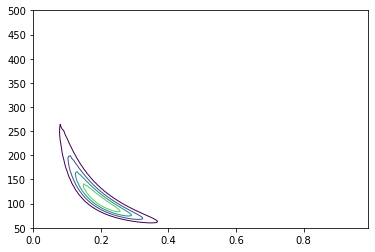

In [13]:
likelihood = joint_pmf.copy()

# As we loop through the pairs of parameters, we compute the likelihood of the data as a in the previous section, 
# and then store the result as an element of likelihood

observed = k01 + k10 + k11
for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = multinomial.pmf(x, N, y)
    
# Now compute the posterior:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

# now plot - we need to `unstack` first to convert from a Series to a DataFrame
from  utils import plot_contour

joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)

This is the joint probability distribution of `N` and `p`. As in the previous model, the most likely values for `N` are around 100, and `p` are around 0.2.

We can also grab the marginals in the usual way:

<AxesSubplot:>

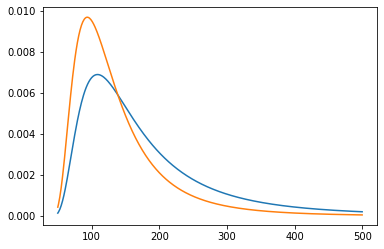

In [14]:
from utils import marginal

posterior2_p = marginal(joint_posterior, 0)
posterior2_N = marginal(joint_posterior, 1)

posterior_N.plot()
posterior2_N.plot()

In [15]:
one_parameter_interval = posterior_N.credible_interval(0.9)
one_parameter_range = one_parameter_interval[1] - one_parameter_interval[0]
two_parameter_interval = posterior2_N.credible_interval(0.9)
two_parameter_range = two_parameter_interval[1] - two_parameter_interval[0]

print(f"{one_parameter_interval} -> {two_parameter_interval}")
print(f"{one_parameter_range} -> {two_parameter_range}")

[ 77. 363.] -> [ 68. 277.]
286.0 -> 209.0


From the graph (\&c.) you can see that the 2-parameter model results in a slightly narrower range.

## The Lincoln Index Problem

John D. Cook writes about the Lincoln Index Problem:

> Suppose that you have a tester who finds 20 bugs in the program. If you have supreme confidence in the tester, you might use this to say that there are about 20 bugs in the program. But what if the tester is not very good? You can cross-check them with another tester. Imagine that you give the same program to another tester, who finds 15 bugs, of which 3 are the same as for the first one. How many bugs do you expect are actually in the program?

The problem is very similar to the Grizzly Bear Problem, so we can represent the data in the same way:

In [16]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In this case, it is almost certainly not the case that we can reasonably assume that the testers have the same probability to find a bug. We'll define two parameters, `p0` and `p1`, to represent the probability that the first and second testers find a bug. We'll also assume that the probabilities are the same for every bug, which is becoming an increasingly untenable position. We'll just go with it though...

In [17]:
# Say we know that the probabilities are 0.2 and 0.15
p0, p1 = 0.2, 0.15

def compute_probs(p0, p1):
    """ Computes the probabilities for each of the four categories """
    q0 = 1 - p0
    q1 = 1 - p1
    return [q0 * q1, q0 * p1, p0 * q1, p0 * p1]

y = compute_probs(p0, p1)
y

[0.68, 0.12, 0.17, 0.03]

So we see that there is a 68\% chance that neither tester finds a bug and a 3\% chance that both do.

When we pretend that we know the probabilities, we can compute the posterior distribution for N:

In [18]:
qs = np.arange(32, 350, step=5)
prior_N = make_uniform(qs)
prior_N.head()

,probs
32,0.015625
37,0.015625
42,0.015625


array([ 77., 127.])

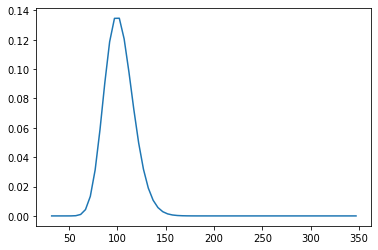

In [19]:
# Put the data in an array with a placeholder value of 0 for the unknown value k00:
data = np.array([0, k10, k01, k11])

# likelihoods
likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, y)
    
posterior_N = prior_N * likelihood
posterior_N.normalize()
posterior_N.plot()
posterior_N.credible_interval(0.9)

Of course, this is based on the assumption that we know the probabilities!

## Three-Parameter Model

We now need three parameters: `N`, `p0`, and `p1`.

In [20]:
qs = np.linspace(0, 1, num=51)
prior_p0 = make_uniform(qs)
prior_p1 = make_uniform(qs)

# Now we need to assemble them into a joint prior w/ 3 dimensions
joint2 = make_joint(prior_p0, prior_N)
joint2.shape

(64, 51)

In [21]:
# Now stack as in the previous example and put the result in a Pmf:
joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head()

32  0.00    0.000306
    0.02    0.000306
    0.04    0.000306
Name: , dtype: float64

In [22]:
# Now let's do the same thing for the third parameter
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape

(3264, 51)

In [23]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head()

32  0.0  0.00    0.000006
         0.02    0.000006
         0.04    0.000006
Name: , dtype: float64

(N, p0, p1)

In [24]:
joint3_pmf.shape

(166464,)

This is still a reasonable number to compute, but it is definitely getting slower...

In [25]:
# Again, we loop through to compute the likelihood of each combination of paramters:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = multinomial.pmf(x, N, y)

posterior_pmf = joint3_pmf * likelihood
posterior_pmf.normalize()

8.941088283758225e-06

In [26]:
# While we could unstack this to get the marginal, there is already a method built in to Pmf that works on Pmfs rather than DataFrames:
posterior_N = posterior_pmf.marginal(0)

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


<AxesSubplot:>

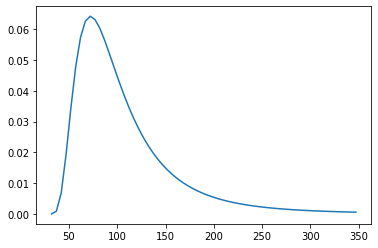

In [27]:
posterior_N.plot()

In [28]:
posterior_N.mean(), posterior_N.credible_interval(0.9)

(105.76561732196248, array([ 52., 207.]))

The posterior mean is 105, which suggests that there are many bugs the testers have not found!

## Exercises

### Exercise 15-1
In an excellent paper, Anne Chao explins how mark and recapture experimens are used in epidemiology to estimate the prevaluece of a disease in a human population based on multiple incomplete lists of cases

One of the examples from the paper is a study "to estimate the number of peope who were infected by hepatitis in an outbreak that occureed in and arounf a collelge in nrther Taiwan from April to July 1995".

Three lists of cases were available
1. 135 cases identified using a serum test
2. 122 cases reported by a local hospital
3. 126 cases reported on questionnaires collected by epidemiologists

In  this exercise, we'll just use the first two lists; in the next we'll bring in the third.

Make a joint prior and update it using this data, then compute the posterior mean of `N` and a 90\% credible interval.

### Solution 15-1

In [29]:
# Start with the data. I probably could have calculated this from the actual data in the paper, but instead I'll just copy it from the solution:
data = np.array([0, 73, 86, 49]) # neither list, only second, only first, both: k00, k01, k10, k11

# We'll do this with two parameters: `N` and `p`. Again, we'll assume that `p` is the same for both lists
Ns = np.arange(1, 601) # this can probably be reformed...
prior_N_pmf = make_uniform(Ns)
ps = np.linspace(0, 1, num=101)
prior_p_pmf = make_uniform(ps)

joint_prior = make_joint(prior_p_pmf,prior_N_pmf)
print(joint_prior.shape)
joint_prior = Pmf(joint_prior.stack())
joint_prior.head()

(600, 101)


1  0.00    0.000017
   0.01    0.000017
   0.02    0.000017
Name: , dtype: float64

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/scipy/stats/_multivariate.py:3053: RuntimeWarning: invalid value encountered in subtract
  return gammaln(n+1) + np.sum(xlogy(x, p) - gammaln(x+1), axis=-1)


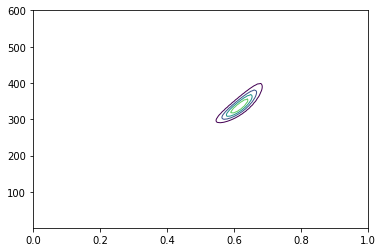

In [30]:
# computing the likelihood:
likelihood = joint_prior.copy()
for N, p in joint_prior.index:
    new_data = data.copy()
    new_data[0] = N - data.sum()
    q = 1 - p
    probs = [p*p, p*q, q*p, q*q]
    likelihood[N, p] = multinomial.pmf(new_data, N, probs)

posterior = joint_prior * likelihood
posterior.normalize()
plot_contour(posterior.unstack())

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


<AxesSubplot:>

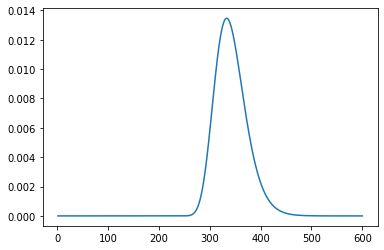

In [31]:
# let's plot the marginals:
marginal_N = posterior.marginal(0)
marginal_N.plot()

In [32]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(342.1665340528433, array([297., 398.]))

### Exercise 15-2

> Now let's do the same thing, but with all three lists. Here's the data from Chao's paper:

data = 28, 21, 17, 69, 18, 55, 63, 0
(data is serum test, national quarantine service, epidemiologists' questionnaires
k111, k110, k101, k100, k011, k010, k001, k000 = data

> Write a loop that computes the likelihood of the data for each pair of parameters, then update the prior and compute the posterior mean of `N`. How does it compare to the results using only the first two lists?

### Solution 15-2

In [33]:
# (Apparently the solution is still working off of the two-parameter model, just slightly different)
base_data = np.array([28, 21, 17, 69, 18, 55, 63, 0])
Ns = np.arange(1, 601)
ps = np.linspace(0, 1, num=101)
prior_Ns = make_uniform(Ns)
prior_ps = make_uniform(ps)

joint_prior = make_joint(prior_ps, prior_Ns)
joint_prior = Pmf(joint_prior.stack())
print(joint_prior.shape)
joint_prior.head()

(60600,)


1  0.00    0.000017
   0.01    0.000017
   0.02    0.000017
Name: , dtype: float64

/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/scipy/stats/_multivariate.py:3053: RuntimeWarning: invalid value encountered in subtract
  return gammaln(n+1) + np.sum(xlogy(x, p) - gammaln(x+1), axis=-1)


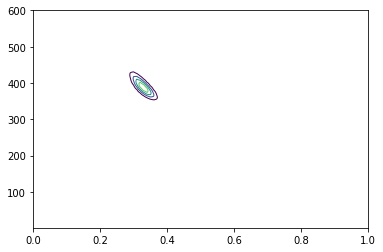

In [34]:
# compute the likelihood
likelihood = joint_prior.copy()
for N, p in joint_prior.index:
    data = base_data.copy()
    data[-1] = N - base_data.sum()
    
    # calculate the probabilities - there is definitely an easier way to do this, but OK
    q = 1 - p
    probs = [p ** 3, p**2 * q, p ** 2 * q, p * q ** 2, p ** 2 * q, p * q ** 2, p * q ** 2, q ** 3]
    likelihood[N, p] = multinomial.pmf(data, N, probs)
    
posterior = joint_prior * likelihood
posterior.normalize()
posterior.head()
plot_contour(posterior.unstack())

391.0143304098154 [358. 430.]


/home/eric/documents/tutorials/ThinkBayes/venv/lib/python3.8/site-packages/empiricaldist/empiricaldist.py:673: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  return Pmf(self.sum(level=i))


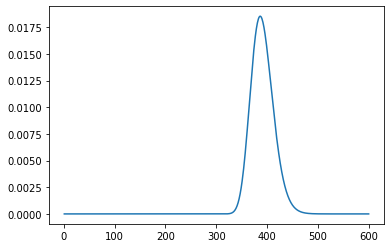

In [35]:
posterior_N = posterior.marginal(0)
posterior_N.plot()
print(posterior_N.mean(), posterior_N.credible_interval(0.9))

(<AxesSubplot:>, <AxesSubplot:>)

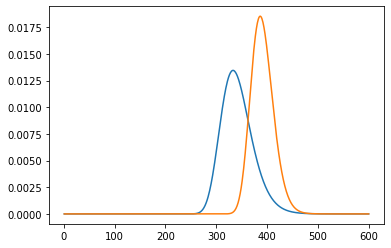

In [36]:
marginal_N.plot(), posterior_N.plot()

In [37]:
print(f"Two lists: {marginal_N.mean()}; three lists: {posterior_N.mean()}")
print(f"Two lists: {marginal_N.credible_interval(0.9)}; three lists: {posterior_N.credible_interval(0.9)}")

Two lists: 342.1665340528433; three lists: 391.0143304098154
Two lists: [297. 398.]; three lists: [358. 430.]


So with the three lists, out mean is a bit higher and a bit tighter.